# ECE239AS Activation function study
# Kai Fukami (UCLA)

In [1]:
from keras.layers import Input, Add, Dense, Conv2D, merge, Conv2DTranspose, MaxPooling2D, AveragePooling2D, UpSampling2D, Flatten, Reshape, LSTM
from keras.models import Model
from keras import backend as K
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})
plt.rc('text', usetex=True)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('font', family='Times New Roman')

Using TensorFlow backend.
/home/fukami/.pyenv/versions/anaconda3-5.1.0/envs/kaif/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fukami/.pyenv/versions/anaconda3-5.1.0/envs/kaif/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fukami/.pyenv/versions/anaconda3-5.1.0/envs/kaif/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint1

In [4]:
import copy
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy as cp

In [5]:
def data_generator(tstep,y0,y1,force_idx):
    y = np.zeros((tstep)); u = np.zeros((tstep))
    y[0] = y0; y[1] = y1;
    u[0] = np.random.normal(0,0.04); 
    u[1] = np.random.normal(0,0.04);
    counter = 0
    if force_idx == True:
        for t in tqdm(range(2,tstep)):
            F = 0.8 - 0.5*np.exp(-(y[t-1])**2)*y[t-1]
            G = -(0.3+0.9*np.exp(-(y[t-1])**2))*y[t-2]
            H = u[t-1]+0.2*u[t-2]
            I = 0.1*u[t-1]*u[t-2]
            et = np.random.uniform()
            u[t] = np.random.normal(0,0.04)
            y[t] = F+G+H+I+et
    elif force_idx == False:
        for t in tqdm(range(2,tstep)):
            F = 0.8 - 0.5*np.exp(-(y[t-1])**2)*y[t-1]
            G = -(0.3+0.9*np.exp(-(y[t-1])**2))*y[t-2]
            y[t] = F+G
    return (y, u)

## Forced case

In [6]:
tstep = 500
y0 = 0.01; y1 = 0.1;
force_idx = True;
y_1,u_1 = data_generator(tstep,y0,y1,force_idx)

100%|██████████| 498/498 [00:00<00:00, 79717.71it/s]


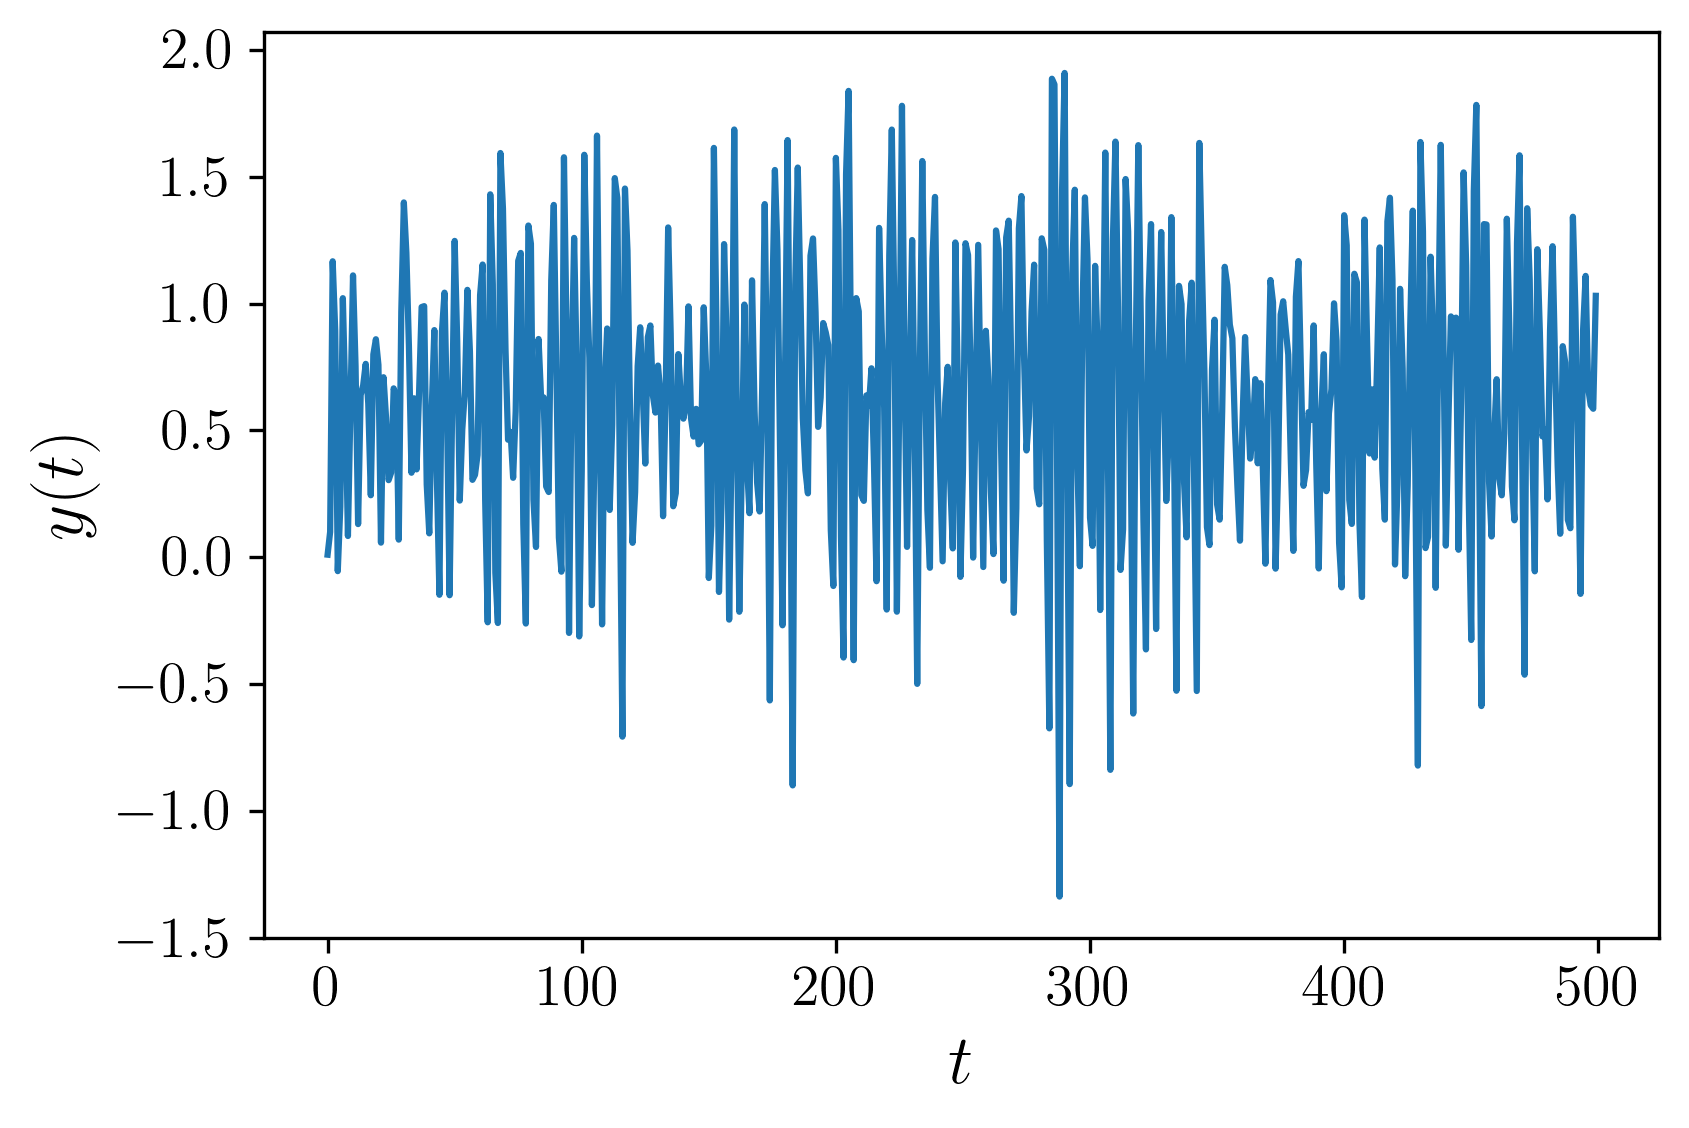

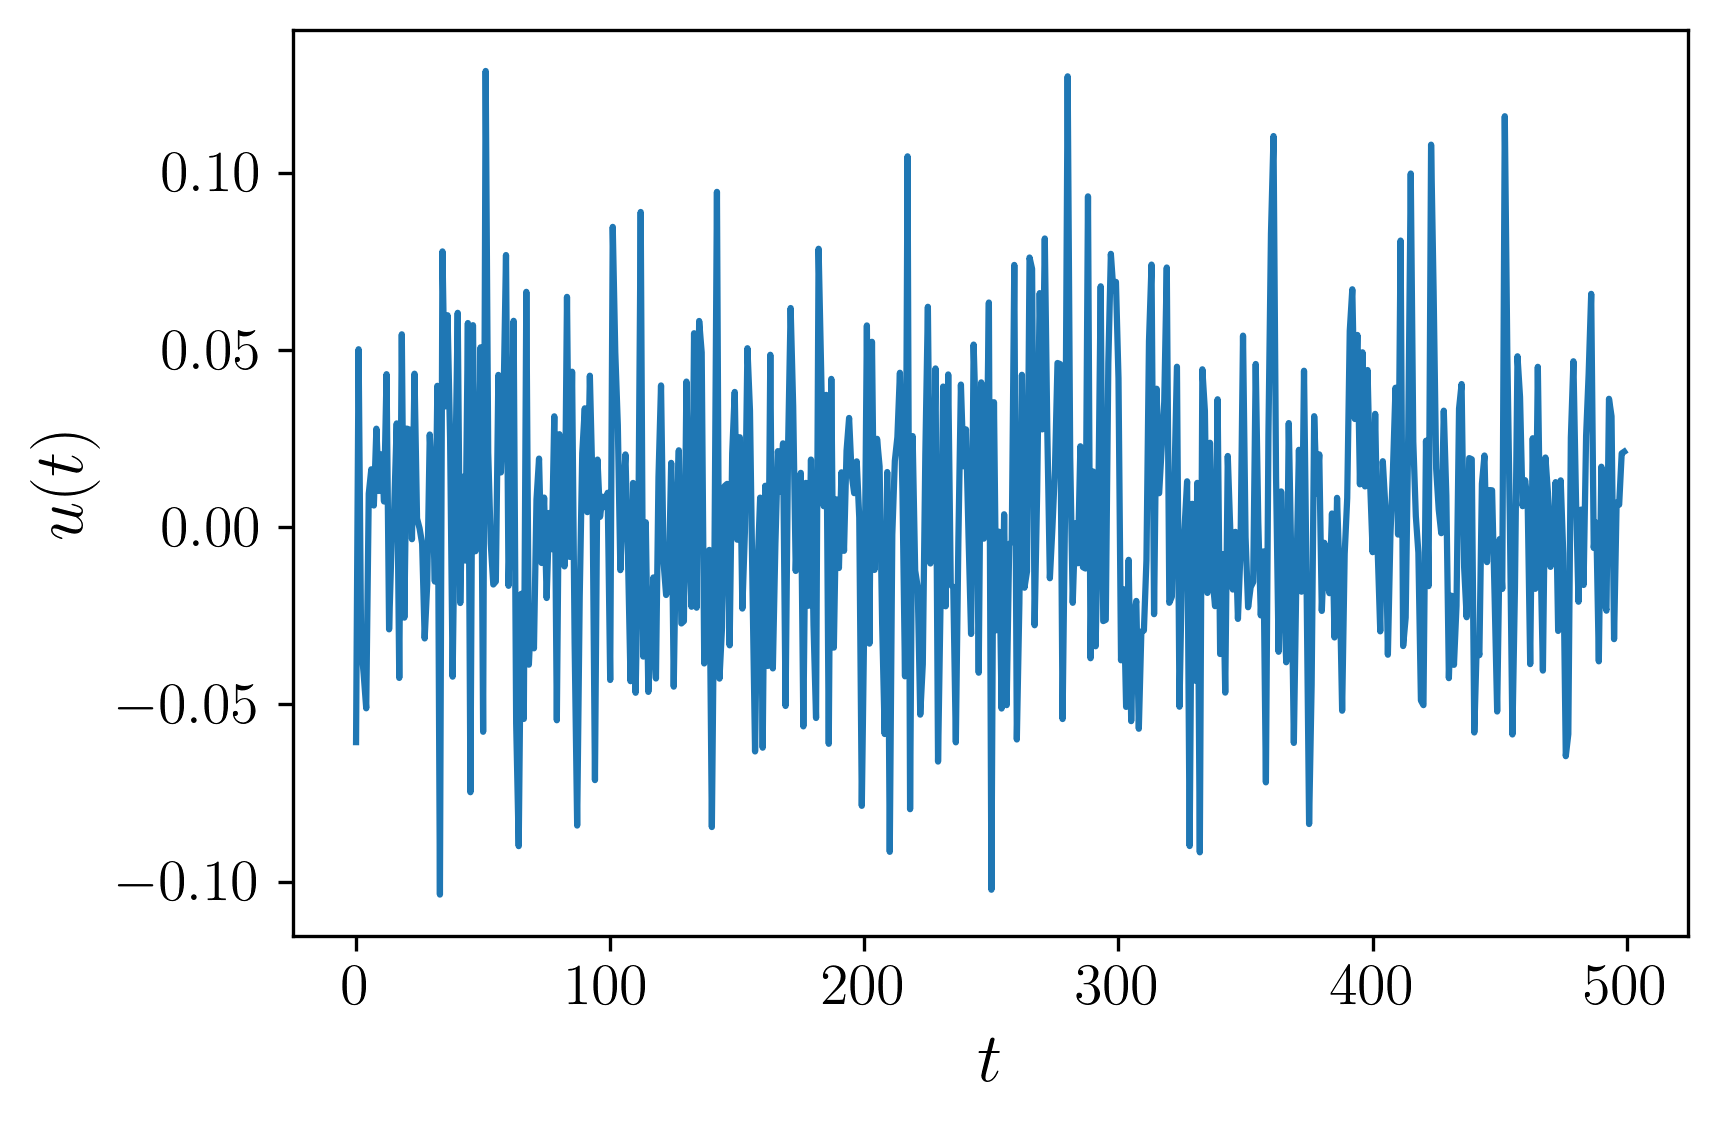

In [7]:
fig = plt.figure(dpi=300)
plt.plot(y_1)
plt.xlabel(r'$t$',fontsize=17)
plt.ylabel(r'$y(t)$',fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

fig = plt.figure(dpi=300)
plt.plot(u_1)
plt.xlabel(r'$t$',fontsize=17)
plt.ylabel(r'$u(t)$',fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [8]:
X_1 = np.zeros((tstep-2,4)) #y0,y1,u0,u1
X_1[:,0] = y_1[:(tstep-2)]
X_1[:,1] = y_1[1:(tstep-1)]
X_1[:,2] = u_1[:(tstep-2)]
X_1[:,3] = u_1[1:(tstep-1)]

X_2 = np.zeros((tstep-2,1))
X_2[:,0] = y_1[2:]

In [12]:
import copy
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy as cp



act = 'relu' #sigmoid, tanh, relu, softplus

input_img = Input(shape=(4,))
x1 = Dense(5, activation=act)(input_img)
x_final = Dense(1)(x1)
model = Model(input_img, x_final)
model.compile(optimizer='adam', loss='mse')


from keras.callbacks import ModelCheckpoint,EarlyStopping
X_train, X_val, y_train, y_val = train_test_split(X_1, X_2, test_size=0.3, random_state=None)

model_cb=ModelCheckpoint('./forced-model-relu.hdf5', monitor='val_loss',save_best_only=True,verbose=1)
early_cb=EarlyStopping(monitor='val_loss', patience=100,verbose=1)
cb = [model_cb, early_cb]
history = model.fit(X_train,y_train,epochs=50000,batch_size=32,verbose=1,callbacks=cb,shuffle=True,validation_data=[X_val, y_val])
df_results = pd.DataFrame(history.history)
df_results['epoch'] = history.epoch
df_results.to_csv(path_or_buf='./forced-model-relu.csv',index=False)

Train on 348 samples, validate on 150 samples
Epoch 1/50000
348/348 [==============================] - 0s 779us/step - loss: 0.9310 - val_loss: 1.0068

Epoch 00001: val_loss improved from inf to 1.00677, saving model to ./forced-model-relu.hdf5
Epoch 2/50000
348/348 [==============================] - 0s 122us/step - loss: 0.8176 - val_loss: 0.8879

Epoch 00002: val_loss improved from 1.00677 to 0.88789, saving model to ./forced-model-relu.hdf5
Epoch 3/50000
348/348 [==============================] - 0s 119us/step - loss: 0.7241 - val_loss: 0.7888

Epoch 00003: val_loss improved from 0.88789 to 0.78877, saving model to ./forced-model-relu.hdf5
Epoch 4/50000
348/348 [==============================] - 0s 112us/step - loss: 0.6484 - val_loss: 0.7109

Epoch 00004: val_loss improved from 0.78877 to 0.71091, saving model to ./forced-model-relu.hdf5
Epoch 5/50000
348/348 [==============================] - 0s 113us/step - loss: 0.5918 - val_loss: 0.6500

Epoch 00005: val_loss improved from 0.71

Epoch 41/50000
348/348 [==============================] - 0s 112us/step - loss: 0.1984 - val_loss: 0.2049

Epoch 00041: val_loss improved from 0.20893 to 0.20494, saving model to ./forced-model-relu.hdf5
Epoch 42/50000
348/348 [==============================] - 0s 107us/step - loss: 0.1949 - val_loss: 0.2012

Epoch 00042: val_loss improved from 0.20494 to 0.20115, saving model to ./forced-model-relu.hdf5
Epoch 43/50000
348/348 [==============================] - 0s 109us/step - loss: 0.1913 - val_loss: 0.1975

Epoch 00043: val_loss improved from 0.20115 to 0.19749, saving model to ./forced-model-relu.hdf5
Epoch 44/50000
348/348 [==============================] - 0s 119us/step - loss: 0.1880 - val_loss: 0.1942

Epoch 00044: val_loss improved from 0.19749 to 0.19419, saving model to ./forced-model-relu.hdf5
Epoch 45/50000
348/348 [==============================] - 0s 117us/step - loss: 0.1850 - val_loss: 0.1907

Epoch 00045: val_loss improved from 0.19419 to 0.19068, saving model to ./for

348/348 [==============================] - 0s 111us/step - loss: 0.1264 - val_loss: 0.1308

Epoch 00123: val_loss did not improve from 0.13040
Epoch 124/50000
348/348 [==============================] - 0s 117us/step - loss: 0.1262 - val_loss: 0.1300

Epoch 00124: val_loss improved from 0.13040 to 0.12997, saving model to ./forced-model-relu.hdf5
Epoch 125/50000
348/348 [==============================] - 0s 114us/step - loss: 0.1259 - val_loss: 0.1298

Epoch 00125: val_loss improved from 0.12997 to 0.12979, saving model to ./forced-model-relu.hdf5
Epoch 126/50000
348/348 [==============================] - 0s 110us/step - loss: 0.1259 - val_loss: 0.1299

Epoch 00126: val_loss did not improve from 0.12979
Epoch 127/50000
348/348 [==============================] - 0s 110us/step - loss: 0.1256 - val_loss: 0.1295

Epoch 00127: val_loss improved from 0.12979 to 0.12950, saving model to ./forced-model-relu.hdf5
Epoch 128/50000
348/348 [==============================] - 0s 126us/step - loss: 0.

348/348 [==============================] - 0s 111us/step - loss: 0.1138 - val_loss: 0.1144

Epoch 00210: val_loss did not improve from 0.11424
Epoch 211/50000
348/348 [==============================] - 0s 110us/step - loss: 0.1133 - val_loss: 0.1140

Epoch 00211: val_loss improved from 0.11424 to 0.11401, saving model to ./forced-model-relu.hdf5
Epoch 212/50000
348/348 [==============================] - 0s 114us/step - loss: 0.1133 - val_loss: 0.1134

Epoch 00212: val_loss improved from 0.11401 to 0.11337, saving model to ./forced-model-relu.hdf5
Epoch 213/50000
348/348 [==============================] - 0s 112us/step - loss: 0.1132 - val_loss: 0.1132

Epoch 00213: val_loss improved from 0.11337 to 0.11321, saving model to ./forced-model-relu.hdf5
Epoch 214/50000
348/348 [==============================] - 0s 106us/step - loss: 0.1134 - val_loss: 0.1142

Epoch 00214: val_loss did not improve from 0.11321
Epoch 215/50000
348/348 [==============================] - 0s 122us/step - loss: 0.

348/348 [==============================] - 0s 115us/step - loss: 0.1062 - val_loss: 0.1054

Epoch 00254: val_loss improved from 0.10593 to 0.10541, saving model to ./forced-model-relu.hdf5
Epoch 255/50000
348/348 [==============================] - 0s 114us/step - loss: 0.1061 - val_loss: 0.1048

Epoch 00255: val_loss improved from 0.10541 to 0.10477, saving model to ./forced-model-relu.hdf5
Epoch 256/50000
348/348 [==============================] - 0s 122us/step - loss: 0.1060 - val_loss: 0.1050

Epoch 00256: val_loss did not improve from 0.10477
Epoch 257/50000
348/348 [==============================] - 0s 103us/step - loss: 0.1058 - val_loss: 0.1052

Epoch 00257: val_loss did not improve from 0.10477
Epoch 258/50000
348/348 [==============================] - 0s 113us/step - loss: 0.1056 - val_loss: 0.1049

Epoch 00258: val_loss did not improve from 0.10477
Epoch 259/50000
348/348 [==============================] - 0s 110us/step - loss: 0.1054 - val_loss: 0.1045

Epoch 00259: val_loss

348/348 [==============================] - 0s 113us/step - loss: 0.0966 - val_loss: 0.0964

Epoch 00346: val_loss improved from 0.09639 to 0.09638, saving model to ./forced-model-relu.hdf5
Epoch 347/50000
348/348 [==============================] - 0s 105us/step - loss: 0.0967 - val_loss: 0.0962

Epoch 00347: val_loss improved from 0.09638 to 0.09615, saving model to ./forced-model-relu.hdf5
Epoch 348/50000
348/348 [==============================] - 0s 109us/step - loss: 0.0964 - val_loss: 0.0966

Epoch 00348: val_loss did not improve from 0.09615
Epoch 349/50000
348/348 [==============================] - 0s 107us/step - loss: 0.0964 - val_loss: 0.0967

Epoch 00349: val_loss did not improve from 0.09615
Epoch 350/50000
348/348 [==============================] - 0s 111us/step - loss: 0.0964 - val_loss: 0.0967

Epoch 00350: val_loss did not improve from 0.09615
Epoch 351/50000
348/348 [==============================] - 0s 121us/step - loss: 0.0962 - val_loss: 0.0961

Epoch 00351: val_loss


Epoch 00393: val_loss improved from 0.09364 to 0.09324, saving model to ./forced-model-relu.hdf5
Epoch 394/50000
348/348 [==============================] - 0s 112us/step - loss: 0.0939 - val_loss: 0.0941

Epoch 00394: val_loss did not improve from 0.09324
Epoch 395/50000
348/348 [==============================] - 0s 113us/step - loss: 0.0939 - val_loss: 0.0938

Epoch 00395: val_loss did not improve from 0.09324
Epoch 396/50000
348/348 [==============================] - 0s 118us/step - loss: 0.0938 - val_loss: 0.0940

Epoch 00396: val_loss did not improve from 0.09324
Epoch 397/50000
348/348 [==============================] - 0s 119us/step - loss: 0.0938 - val_loss: 0.0934

Epoch 00397: val_loss did not improve from 0.09324
Epoch 398/50000
348/348 [==============================] - 0s 108us/step - loss: 0.0937 - val_loss: 0.0935

Epoch 00398: val_loss did not improve from 0.09324
Epoch 399/50000
348/348 [==============================] - 0s 116us/step - loss: 0.0936 - val_loss: 0.0933


348/348 [==============================] - 0s 103us/step - loss: 0.0917 - val_loss: 0.0917

Epoch 00442: val_loss did not improve from 0.09148
Epoch 443/50000
348/348 [==============================] - 0s 109us/step - loss: 0.0919 - val_loss: 0.0917

Epoch 00443: val_loss did not improve from 0.09148
Epoch 444/50000
348/348 [==============================] - 0s 109us/step - loss: 0.0918 - val_loss: 0.0911

Epoch 00444: val_loss improved from 0.09148 to 0.09109, saving model to ./forced-model-relu.hdf5
Epoch 445/50000
348/348 [==============================] - 0s 113us/step - loss: 0.0918 - val_loss: 0.0916

Epoch 00445: val_loss did not improve from 0.09109
Epoch 446/50000
348/348 [==============================] - 0s 123us/step - loss: 0.0917 - val_loss: 0.0918

Epoch 00446: val_loss did not improve from 0.09109
Epoch 447/50000
348/348 [==============================] - 0s 116us/step - loss: 0.0919 - val_loss: 0.0911

Epoch 00447: val_loss did not improve from 0.09109
Epoch 448/50000


348/348 [==============================] - 0s 106us/step - loss: 0.0904 - val_loss: 0.0907

Epoch 00491: val_loss did not improve from 0.09007
Epoch 492/50000
348/348 [==============================] - 0s 105us/step - loss: 0.0904 - val_loss: 0.0900

Epoch 00492: val_loss improved from 0.09007 to 0.09000, saving model to ./forced-model-relu.hdf5
Epoch 493/50000
348/348 [==============================] - 0s 121us/step - loss: 0.0904 - val_loss: 0.0898

Epoch 00493: val_loss improved from 0.09000 to 0.08977, saving model to ./forced-model-relu.hdf5
Epoch 494/50000
348/348 [==============================] - 0s 114us/step - loss: 0.0903 - val_loss: 0.0902

Epoch 00494: val_loss did not improve from 0.08977
Epoch 495/50000
348/348 [==============================] - 0s 105us/step - loss: 0.0902 - val_loss: 0.0902

Epoch 00495: val_loss did not improve from 0.08977
Epoch 496/50000
348/348 [==============================] - 0s 109us/step - loss: 0.0903 - val_loss: 0.0900

Epoch 00496: val_loss

348/348 [==============================] - 0s 116us/step - loss: 0.0898 - val_loss: 0.0890

Epoch 00541: val_loss did not improve from 0.08890
Epoch 542/50000
348/348 [==============================] - 0s 116us/step - loss: 0.0893 - val_loss: 0.0893

Epoch 00542: val_loss did not improve from 0.08890
Epoch 543/50000
348/348 [==============================] - 0s 121us/step - loss: 0.0893 - val_loss: 0.0896

Epoch 00543: val_loss did not improve from 0.08890
Epoch 544/50000
348/348 [==============================] - 0s 111us/step - loss: 0.0897 - val_loss: 0.0897

Epoch 00544: val_loss did not improve from 0.08890
Epoch 545/50000
348/348 [==============================] - 0s 111us/step - loss: 0.0892 - val_loss: 0.0890

Epoch 00545: val_loss did not improve from 0.08890
Epoch 546/50000
348/348 [==============================] - 0s 106us/step - loss: 0.0896 - val_loss: 0.0887

Epoch 00546: val_loss improved from 0.08890 to 0.08875, saving model to ./forced-model-relu.hdf5
Epoch 547/50000


348/348 [==============================] - 0s 113us/step - loss: 0.0890 - val_loss: 0.0893

Epoch 00592: val_loss did not improve from 0.08829
Epoch 593/50000
348/348 [==============================] - 0s 115us/step - loss: 0.0891 - val_loss: 0.0882

Epoch 00593: val_loss improved from 0.08829 to 0.08824, saving model to ./forced-model-relu.hdf5
Epoch 594/50000
348/348 [==============================] - 0s 104us/step - loss: 0.0886 - val_loss: 0.0888

Epoch 00594: val_loss did not improve from 0.08824
Epoch 595/50000
348/348 [==============================] - 0s 111us/step - loss: 0.0886 - val_loss: 0.0885

Epoch 00595: val_loss did not improve from 0.08824
Epoch 596/50000
348/348 [==============================] - 0s 104us/step - loss: 0.0889 - val_loss: 0.0882

Epoch 00596: val_loss improved from 0.08824 to 0.08815, saving model to ./forced-model-relu.hdf5
Epoch 597/50000
348/348 [==============================] - 0s 117us/step - loss: 0.0890 - val_loss: 0.0899

Epoch 00597: val_loss

348/348 [==============================] - 0s 121us/step - loss: 0.0875 - val_loss: 0.0873

Epoch 00691: val_loss did not improve from 0.08723
Epoch 692/50000
348/348 [==============================] - 0s 114us/step - loss: 0.0876 - val_loss: 0.0871

Epoch 00692: val_loss improved from 0.08723 to 0.08711, saving model to ./forced-model-relu.hdf5
Epoch 693/50000
348/348 [==============================] - 0s 105us/step - loss: 0.0874 - val_loss: 0.0877

Epoch 00693: val_loss did not improve from 0.08711
Epoch 694/50000
348/348 [==============================] - 0s 112us/step - loss: 0.0880 - val_loss: 0.0882

Epoch 00694: val_loss did not improve from 0.08711
Epoch 695/50000
348/348 [==============================] - 0s 117us/step - loss: 0.0876 - val_loss: 0.0875

Epoch 00695: val_loss did not improve from 0.08711
Epoch 696/50000
348/348 [==============================] - 0s 125us/step - loss: 0.0874 - val_loss: 0.0870

Epoch 00696: val_loss improved from 0.08711 to 0.08704, saving mode

348/348 [==============================] - 0s 118us/step - loss: 0.0869 - val_loss: 0.0871

Epoch 00791: val_loss did not improve from 0.08635
Epoch 792/50000
348/348 [==============================] - 0s 109us/step - loss: 0.0872 - val_loss: 0.0876

Epoch 00792: val_loss did not improve from 0.08635
Epoch 793/50000
348/348 [==============================] - 0s 115us/step - loss: 0.0870 - val_loss: 0.0867

Epoch 00793: val_loss did not improve from 0.08635
Epoch 794/50000
348/348 [==============================] - 0s 115us/step - loss: 0.0872 - val_loss: 0.0868

Epoch 00794: val_loss did not improve from 0.08635
Epoch 795/50000
348/348 [==============================] - 0s 114us/step - loss: 0.0874 - val_loss: 0.0871

Epoch 00795: val_loss did not improve from 0.08635
Epoch 796/50000
348/348 [==============================] - 0s 107us/step - loss: 0.0876 - val_loss: 0.0863

Epoch 00796: val_loss improved from 0.08635 to 0.08626, saving model to ./forced-model-relu.hdf5
Epoch 797/50000


348/348 [==============================] - 0s 115us/step - loss: 0.0870 - val_loss: 0.0865

Epoch 00842: val_loss did not improve from 0.08623
Epoch 843/50000
348/348 [==============================] - 0s 108us/step - loss: 0.0869 - val_loss: 0.0865

Epoch 00843: val_loss did not improve from 0.08623
Epoch 844/50000
348/348 [==============================] - 0s 108us/step - loss: 0.0871 - val_loss: 0.0870

Epoch 00844: val_loss did not improve from 0.08623
Epoch 845/50000
348/348 [==============================] - 0s 114us/step - loss: 0.0869 - val_loss: 0.0868

Epoch 00845: val_loss did not improve from 0.08623
Epoch 846/50000
348/348 [==============================] - 0s 122us/step - loss: 0.0869 - val_loss: 0.0866

Epoch 00846: val_loss did not improve from 0.08623
Epoch 847/50000
348/348 [==============================] - 0s 106us/step - loss: 0.0868 - val_loss: 0.0863

Epoch 00847: val_loss did not improve from 0.08623
Epoch 848/50000
348/348 [==============================] - 0s 

Epoch 893/50000
348/348 [==============================] - 0s 109us/step - loss: 0.0868 - val_loss: 0.0864

Epoch 00893: val_loss did not improve from 0.08591
Epoch 894/50000
348/348 [==============================] - 0s 119us/step - loss: 0.0868 - val_loss: 0.0863

Epoch 00894: val_loss did not improve from 0.08591
Epoch 895/50000
348/348 [==============================] - 0s 118us/step - loss: 0.0867 - val_loss: 0.0865

Epoch 00895: val_loss did not improve from 0.08591
Epoch 896/50000
348/348 [==============================] - 0s 99us/step - loss: 0.0870 - val_loss: 0.0863

Epoch 00896: val_loss did not improve from 0.08591
Epoch 897/50000
348/348 [==============================] - 0s 105us/step - loss: 0.0868 - val_loss: 0.0869

Epoch 00897: val_loss did not improve from 0.08591
Epoch 898/50000
348/348 [==============================] - 0s 116us/step - loss: 0.0867 - val_loss: 0.0864

Epoch 00898: val_loss did not improve from 0.08591
Epoch 899/50000
348/348 [======================

348/348 [==============================] - 0s 111us/step - loss: 0.0867 - val_loss: 0.0861

Epoch 00944: val_loss did not improve from 0.08590
Epoch 945/50000
348/348 [==============================] - 0s 120us/step - loss: 0.0872 - val_loss: 0.0870

Epoch 00945: val_loss did not improve from 0.08590
Epoch 946/50000
348/348 [==============================] - 0s 112us/step - loss: 0.0868 - val_loss: 0.0864

Epoch 00946: val_loss did not improve from 0.08590
Epoch 947/50000
348/348 [==============================] - 0s 115us/step - loss: 0.0867 - val_loss: 0.0861

Epoch 00947: val_loss did not improve from 0.08590
Epoch 948/50000
348/348 [==============================] - 0s 121us/step - loss: 0.0868 - val_loss: 0.0862

Epoch 00948: val_loss did not improve from 0.08590
Epoch 949/50000
348/348 [==============================] - 0s 116us/step - loss: 0.0867 - val_loss: 0.0862

Epoch 00949: val_loss did not improve from 0.08590
Epoch 950/50000
348/348 [==============================] - 0s 

348/348 [==============================] - 0s 111us/step - loss: 0.0866 - val_loss: 0.0864

Epoch 01046: val_loss did not improve from 0.08590
Epoch 1047/50000
348/348 [==============================] - 0s 113us/step - loss: 0.0870 - val_loss: 0.0861

Epoch 01047: val_loss did not improve from 0.08590
Epoch 1048/50000
348/348 [==============================] - 0s 114us/step - loss: 0.0867 - val_loss: 0.0865

Epoch 01048: val_loss did not improve from 0.08590
Epoch 1049/50000
348/348 [==============================] - 0s 101us/step - loss: 0.0866 - val_loss: 0.0862

Epoch 01049: val_loss did not improve from 0.08590
Epoch 1050/50000
348/348 [==============================] - 0s 109us/step - loss: 0.0866 - val_loss: 0.0864

Epoch 01050: val_loss did not improve from 0.08590
Epoch 1051/50000
348/348 [==============================] - 0s 116us/step - loss: 0.0866 - val_loss: 0.0862

Epoch 01051: val_loss did not improve from 0.08590
Epoch 1052/50000
348/348 [==============================]

348/348 [==============================] - 0s 115us/step - loss: 0.0865 - val_loss: 0.0864

Epoch 01097: val_loss did not improve from 0.08584
Epoch 1098/50000
348/348 [==============================] - 0s 117us/step - loss: 0.0866 - val_loss: 0.0864

Epoch 01098: val_loss did not improve from 0.08584
Epoch 1099/50000
348/348 [==============================] - 0s 119us/step - loss: 0.0867 - val_loss: 0.0863

Epoch 01099: val_loss did not improve from 0.08584
Epoch 1100/50000
348/348 [==============================] - 0s 116us/step - loss: 0.0866 - val_loss: 0.0860

Epoch 01100: val_loss did not improve from 0.08584
Epoch 1101/50000
348/348 [==============================] - 0s 110us/step - loss: 0.0872 - val_loss: 0.0866

Epoch 01101: val_loss did not improve from 0.08584
Epoch 1102/50000
348/348 [==============================] - 0s 106us/step - loss: 0.0867 - val_loss: 0.0859

Epoch 01102: val_loss did not improve from 0.08584
Epoch 1103/50000
348/348 [==============================]

In [13]:
from keras.models import load_model
model_sigmoid = load_model('./forced-model-sigmoid.hdf5')
model_tanh = load_model('./forced-model-tanh.hdf5')
model_relu = load_model('./forced-model-relu.hdf5')
model_softplus = load_model('./forced-model-softplus.hdf5')

In [15]:
# X_2_pred = model.predict(X_1,verbose=1)

X_2_pred_hat_0 = np.zeros((tstep))
X_2_pred_hat_0[0] = y0; X_2_pred_hat_0[1] = y1;

X_2_pred_hat_1 = np.zeros((tstep))
X_2_pred_hat_1[0] = y0; X_2_pred_hat_1[1] = y1;

X_2_pred_hat_2 = np.zeros((tstep))
X_2_pred_hat_2[0] = y0; X_2_pred_hat_2[1] = y1;

X_2_pred_hat_3 = np.zeros((tstep))
X_2_pred_hat_3[0] = y0; X_2_pred_hat_3[1] = y1;

u_hat = np.zeros((tstep))
for t in (range(len(u_hat))):
    u_hat[t] = np.random.normal(0,0.04);

for t in tqdm(range(len(X_2_pred_hat_0)-2)):
    input_temp_0 = np.zeros((1,4))
    input_temp_0[0,0] = X_2_pred_hat_0[t]
    input_temp_0[0,1] = X_2_pred_hat_0[t+1]
    input_temp_0[0,2] = u_hat[t]
    input_temp_0[0,3] = u_hat[t+1]
    X_2_pred_hat_0[t+2] = model_sigmoid.predict(input_temp_0)
    
    input_temp_1 = np.zeros((1,4))
    input_temp_1[0,0] = X_2_pred_hat_1[t]
    input_temp_1[0,1] = X_2_pred_hat_1[t+1]
    input_temp_1[0,2] = u_hat[t]
    input_temp_1[0,3] = u_hat[t+1]
    X_2_pred_hat_1[t+2] = model_tanh.predict(input_temp_1)
    
    input_temp_2 = np.zeros((1,4))
    input_temp_2[0,0] = X_2_pred_hat_2[t]
    input_temp_2[0,1] = X_2_pred_hat_2[t+1]
    input_temp_2[0,2] = u_hat[t]
    input_temp_2[0,3] = u_hat[t+1]
    X_2_pred_hat_2[t+2] = model_relu.predict(input_temp_2)
    
    input_temp_3 = np.zeros((1,4))
    input_temp_3[0,0] = X_2_pred_hat_3[t]
    input_temp_3[0,1] = X_2_pred_hat_3[t+1]
    input_temp_3[0,2] = u_hat[t]
    input_temp_3[0,3] = u_hat[t+1]
    X_2_pred_hat_3[t+2] = model_softplus.predict(input_temp_3)

100%|██████████| 498/498 [00:01<00:00, 256.09it/s]


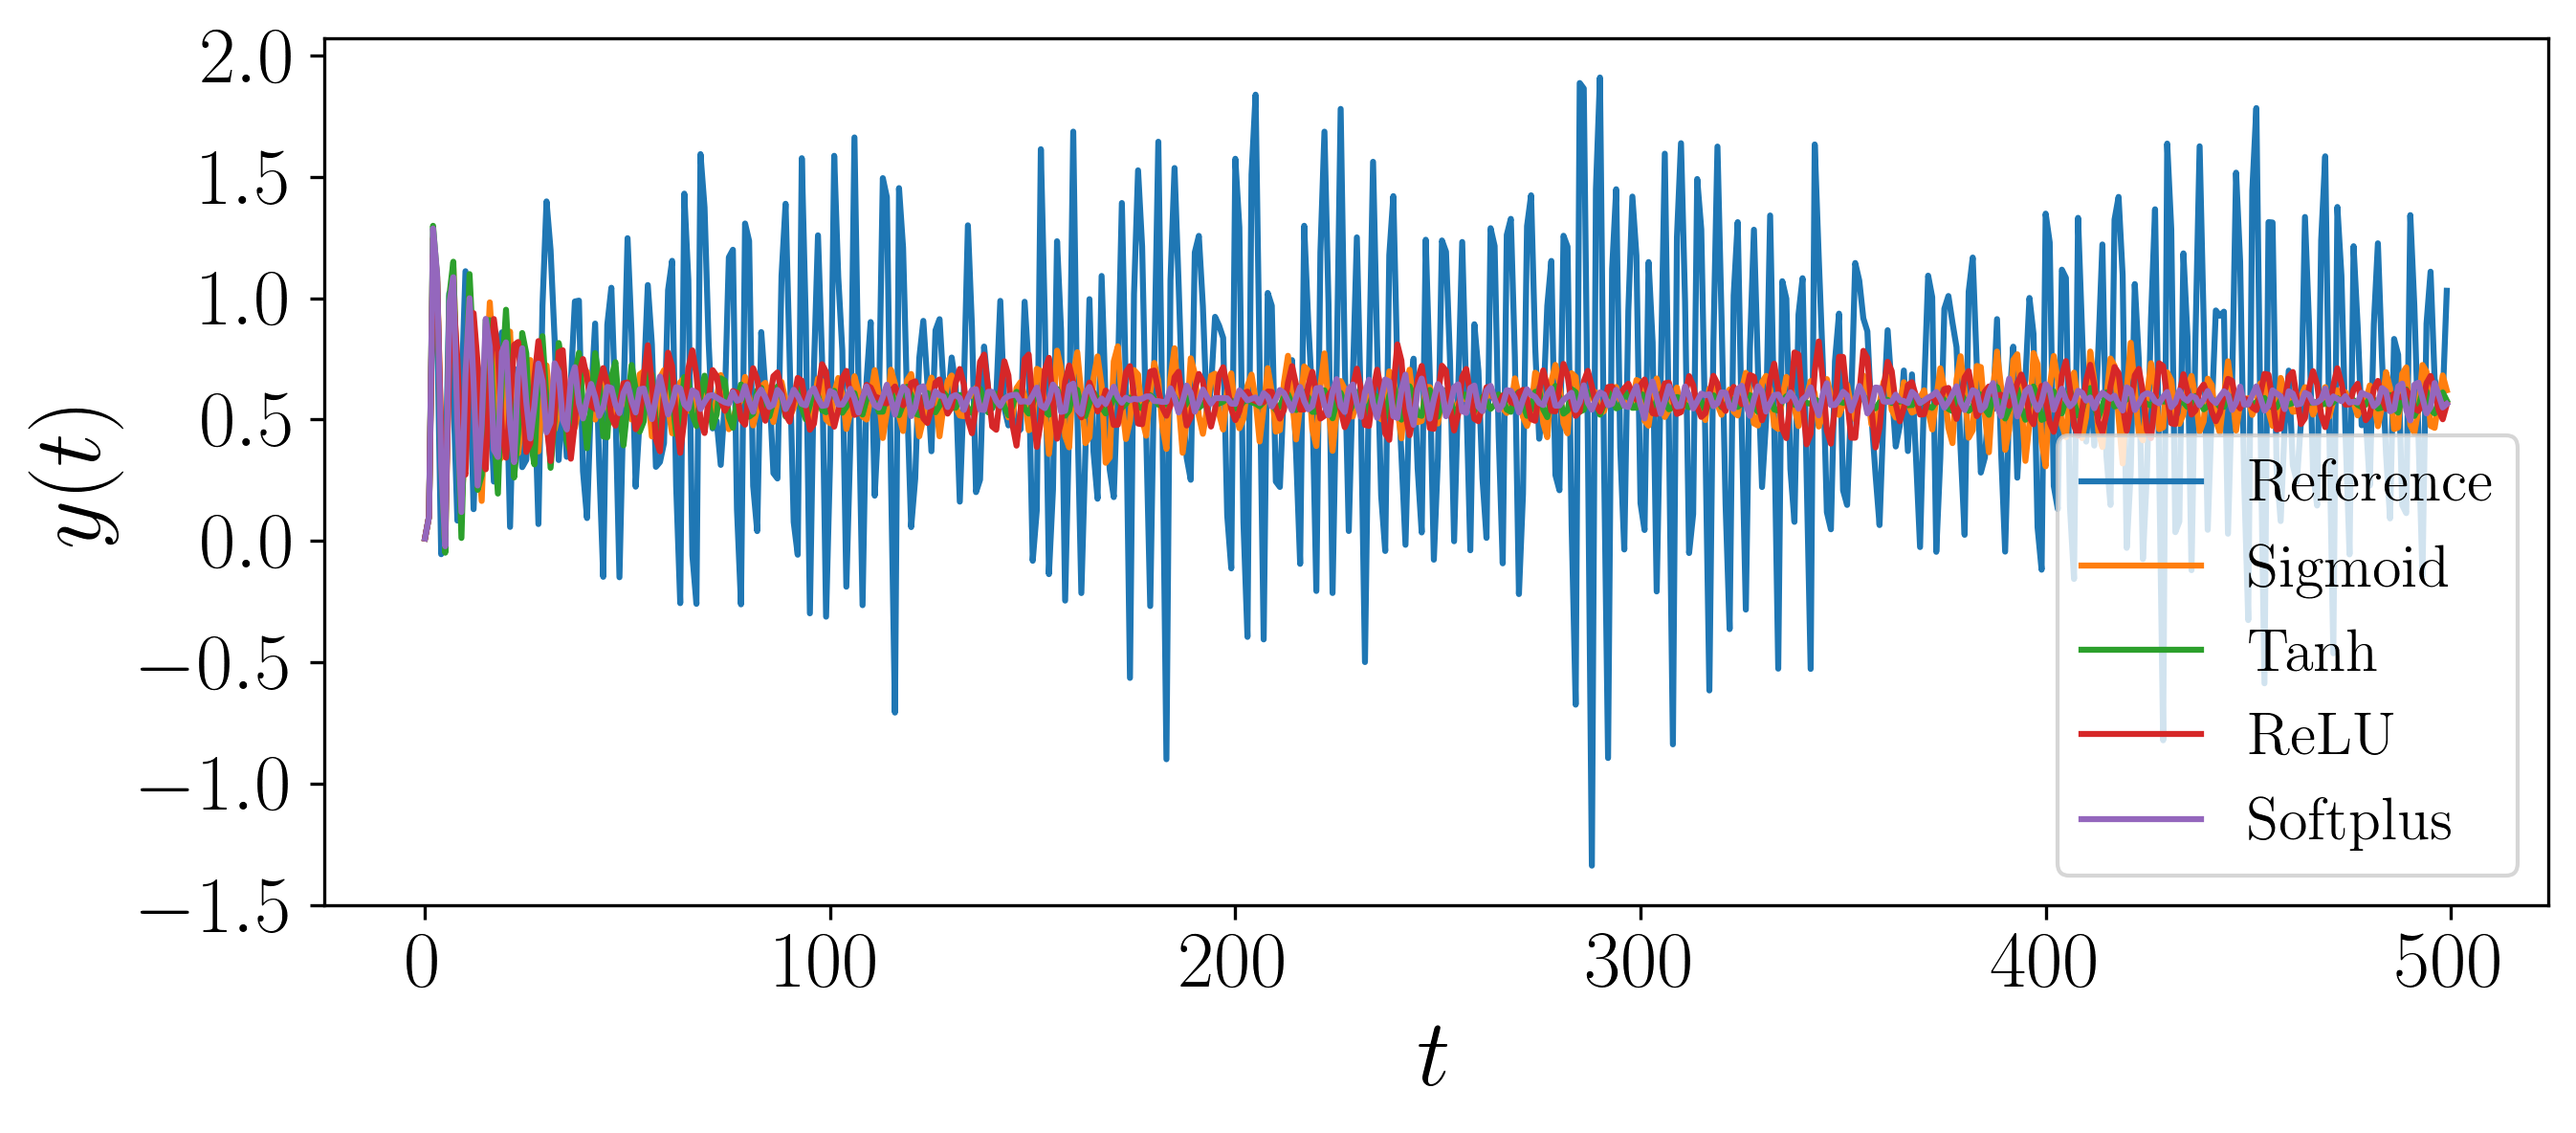

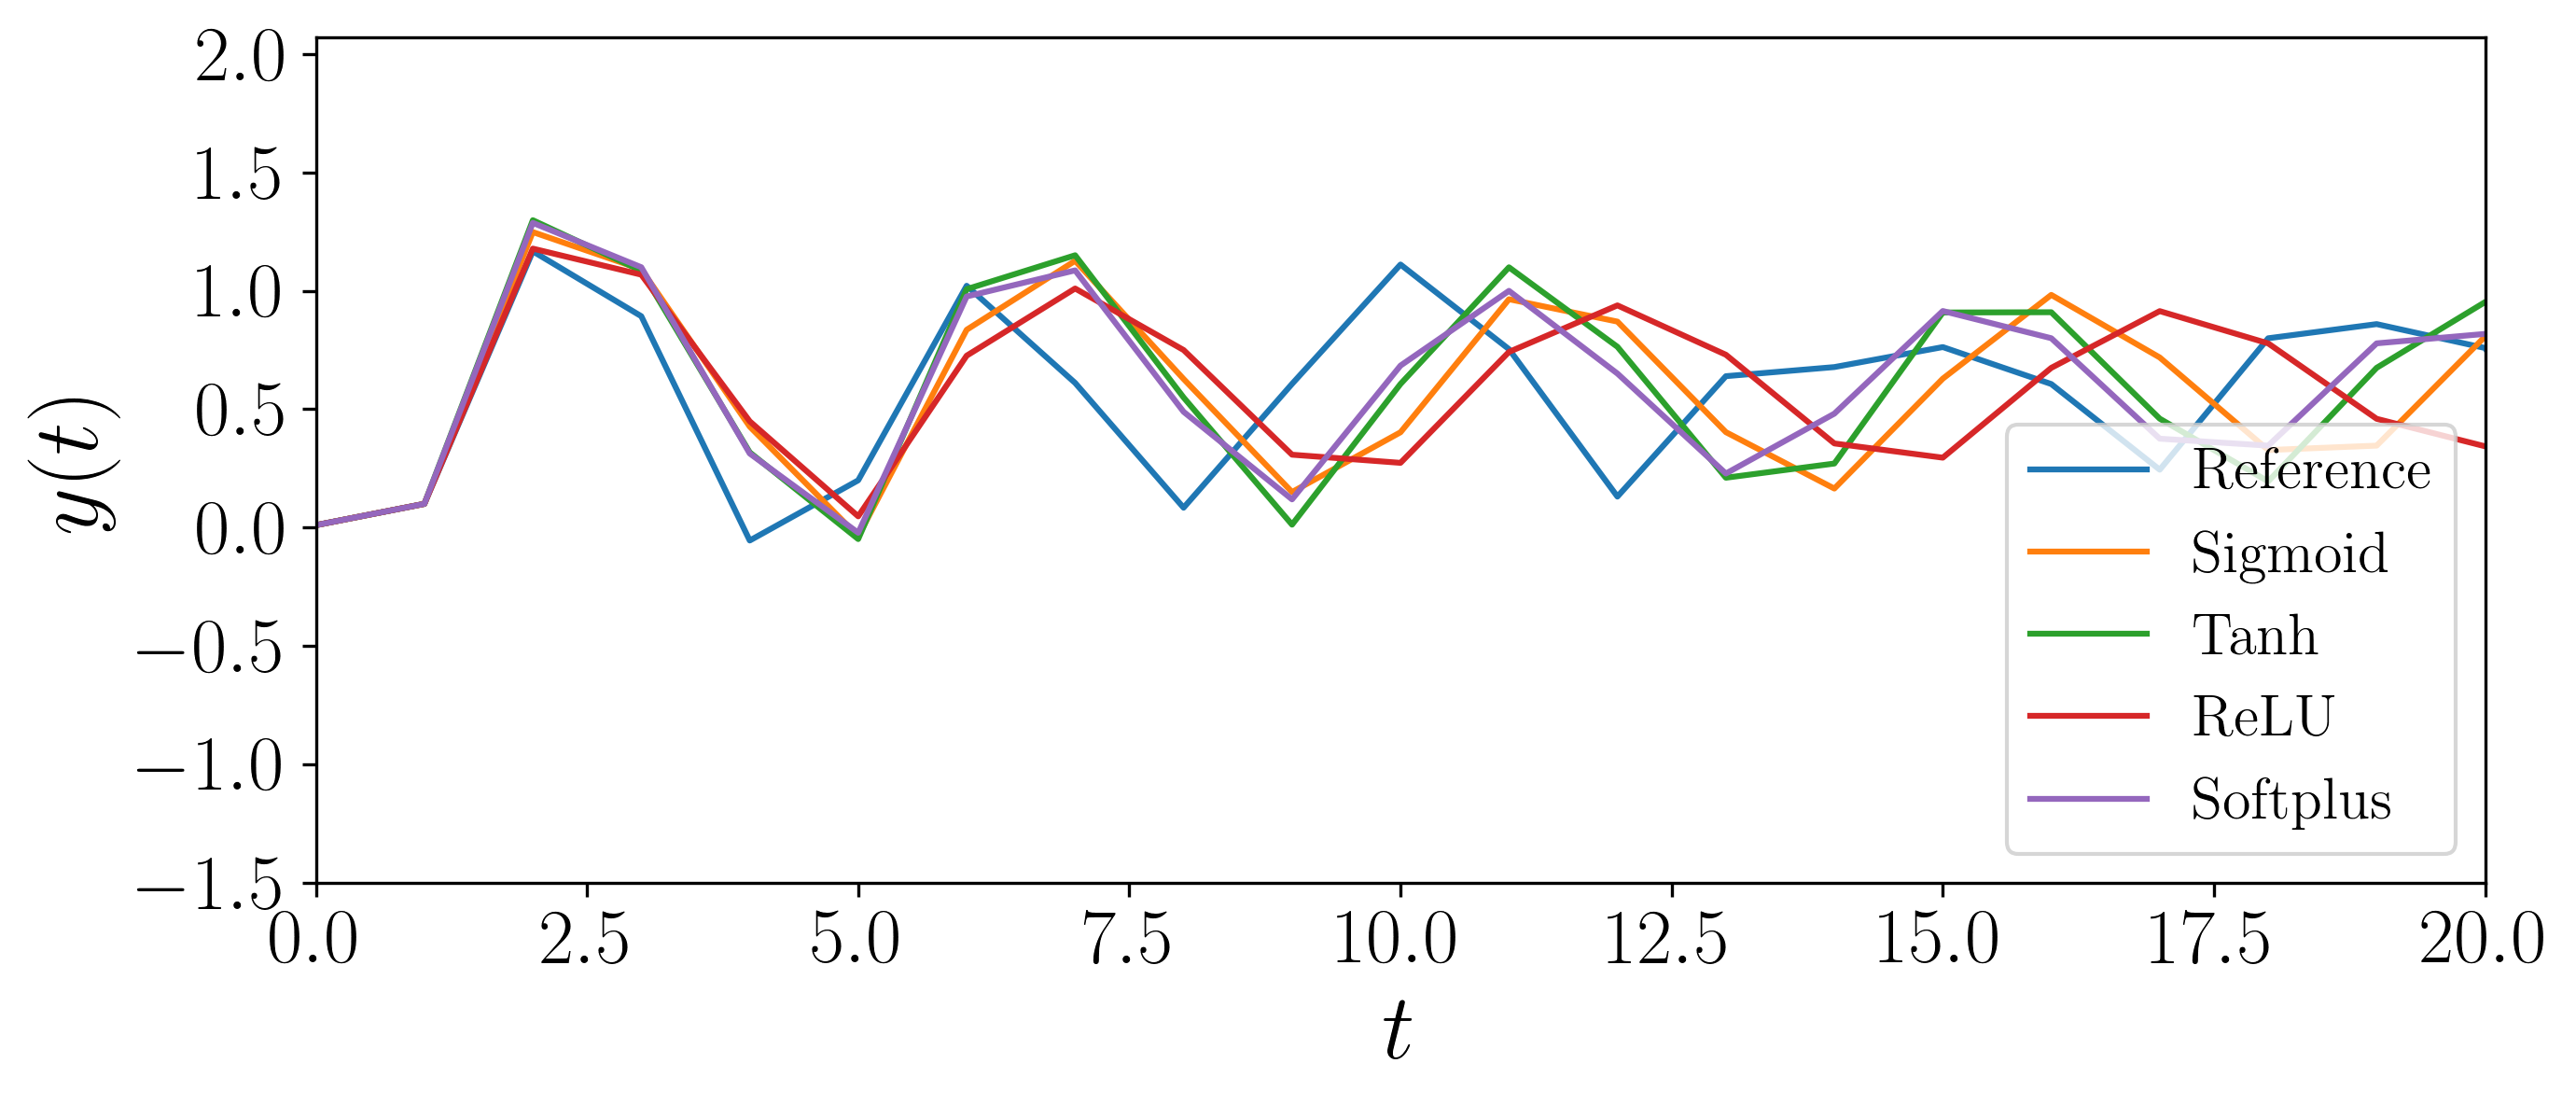

In [17]:
fig = plt.figure(dpi=300,figsize=(10,4))
plt.plot(y_1,label='Reference')
plt.plot(X_2_pred_hat_0,label='Sigmoid')
plt.plot(X_2_pred_hat_1,label='Tanh')
plt.plot(X_2_pred_hat_2,label='ReLU')
plt.plot(X_2_pred_hat_3,label='Softplus')
plt.xlabel(r'$t$',fontsize=24)
plt.ylabel(r'$y(t)$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.show()


fig = plt.figure(dpi=300,figsize=(10,4))
plt.plot(y_1,label='Reference')
plt.plot(X_2_pred_hat_0,label='Sigmoid')
plt.plot(X_2_pred_hat_1,label='Tanh')
plt.plot(X_2_pred_hat_2,label='ReLU')
plt.plot(X_2_pred_hat_3,label='Softplus')
plt.xlabel(r'$t$',fontsize=24)
plt.ylabel(r'$y(t)$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.xlim(0,20)
plt.show()